In [2]:
!pip install numpy matplotlib scikit-image opencv-python scikit-learn optuna cuml-cu12 tqdm

# Import data

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from skimage.io import imread
from skimage.color import rgb2gray, rgb2hsv, rgb2lab, rgb2hed, rgb2yiq
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from skimage.measure import find_contours
import cv2
from cv2 import findContours

import optuna

from cuml.cluster import KMeans, DBSCAN
from cuml.metrics.cluster import silhouette_score

from tqdm import tqdm

In [4]:
pic = imread("./img/lady.jpeg")
pic.shape

(1024, 1024, 3)

In [5]:
pic_grey = rgb2gray(pic)
pic_grey.shape

(1024, 1024)

<Figure size 1300x1300 with 0 Axes>

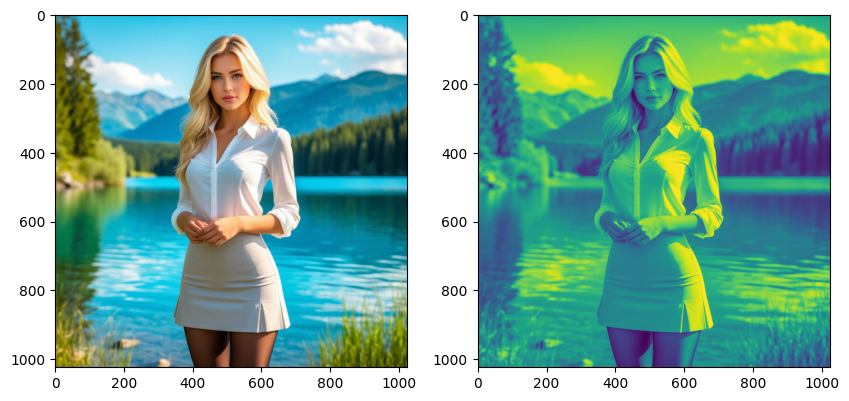

In [6]:
plt.figure(figsize=(13, 13))

fig, ax = plt.subplots(1, 2, figsize=(10, 14))

ax[0].imshow(pic)
ax[1].imshow(pic_grey)


plt.show()

# Prepare data

## Bright

In [7]:
X_b = pic_grey.reshape((-1, 1))
X_b

array([[0.42917882],
       [0.42917882],
       [0.43758745],
       ...,
       [0.40623882],
       [0.36342902],
       [0.27830039]])

## Bright and coordinates

In [8]:
rows, cols = pic_grey.shape
row_coords, col_coords = np.mgrid[:rows, :cols]

In [9]:
X_b_c = np.stack([pic_grey.ravel(), row_coords.ravel(), col_coords.ravel()], axis=1)
X_b_c

array([[4.29178824e-01, 0.00000000e+00, 0.00000000e+00],
       [4.29178824e-01, 0.00000000e+00, 1.00000000e+00],
       [4.37587451e-01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [4.06238824e-01, 1.02300000e+03, 1.02100000e+03],
       [3.63429020e-01, 1.02300000e+03, 1.02200000e+03],
       [2.78300392e-01, 1.02300000e+03, 1.02300000e+03]])

## Sobel operaor (gradient base)

In [10]:
edge_sobel = sobel(pic_grey)
edge_sobel

array([[0.01749008, 0.01626523, 0.01418231, ..., 0.00494602, 0.00384646,
        0.00305069],
       [0.03034045, 0.0271877 , 0.0218712 , ..., 0.0042408 , 0.00280468,
        0.00186507],
       [0.01307901, 0.02076052, 0.02104131, ..., 0.00323296, 0.00261884,
        0.00187078],
       ...,
       [0.01239976, 0.01499127, 0.01695003, ..., 0.025696  , 0.07133226,
        0.06677859],
       [0.00934425, 0.01273765, 0.02183416, ..., 0.03113238, 0.08723622,
        0.07709662],
       [0.00363133, 0.01095112, 0.02684296, ..., 0.02946707, 0.08896887,
        0.06305749]])

In [11]:
X_s = np.stack([edge_sobel.ravel(), row_coords.ravel(), col_coords.ravel()], axis=1)
X_s

array([[1.74900766e-02, 0.00000000e+00, 0.00000000e+00],
       [1.62652253e-02, 0.00000000e+00, 1.00000000e+00],
       [1.41823129e-02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [2.94670680e-02, 1.02300000e+03, 1.02100000e+03],
       [8.89688698e-02, 1.02300000e+03, 1.02200000e+03],
       [6.30574948e-02, 1.02300000e+03, 1.02300000e+03]])

## Standartization

In [12]:
scaler_b = StandardScaler()
scaler_b_c = StandardScaler()
scaler_x = StandardScaler()

In [13]:
X_b = scaler_b.fit_transform(X_b)
X_b_c = scaler_b_c.fit_transform(X_b_c)
x_s = scaler_x.fit_transform(X_s)

# Clusterization

In [14]:
n_clusters = 6
RANDOM_STATE = 42

## Kmeans

In [15]:
# def objective(trial):

#     n_clusters = trial.suggest_int("n_clusters", 3, 18, 2)
#     init = trial.suggest_categorical("init", ["k-means++", "random"])
#     # max_iter = trial.suggest_int("max_iter", 100)
#     algorithm = trial.suggest_categorical("algorithm", ["lloyd", "elkan"])
#     random_state = trial.suggest_int("random_state", 42, 42)

#     kmeans = KMeans(
#         n_clusters=n_clusters,
#         init=init,
#         # max_iter=max_iter,
#         algorithm=algorithm,
#         random_state=random_state
#     )

#     X = X_b_c

#     try:
#         kmeans.fit(X)
#         labels = kmeans.labels_
#         silhouette = silhouette_score(X, labels)

#     except ValueError as e:
#         return -100
    
#     return silhouette

In [16]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_jobs=-1, n_trials=1)

In [17]:
# best_params = study.best_params
# final_kmeans = KMeans(**best_params)

In [18]:
# final_kmeans.fit(X_b)

# labels_b_o = final_kmeans.labels_
# segmented_pic_b_o = labels_b_o.reshape(pic.shape[:2])

In [19]:
# plt.figure(figsize=(15, 20))

# plt.imshow(segmented_pic_b_o)
# plt.show()

### On bright

In [20]:
%%time
kmeans_b = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init='auto', verbose=1)
kmeans_b.fit(X_b)

labels_b = kmeans_b.labels_
segmented_pic_b = labels_b.reshape(pic.shape[:2])

CPU times: user 476 ms, sys: 99.5 ms, total: 575 ms
Wall time: 627 ms


### On brght and coords

In [21]:
%%time
kmeans_bc = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init='auto', verbose=1)
kmeans_bc.fit(X_b_c)

labels_bc = kmeans_bc.labels_
segmented_pic_bc = labels_bc.reshape(pic.shape[:2])

CPU times: user 660 ms, sys: 32.1 ms, total: 692 ms
Wall time: 688 ms


### On sobel gradietn

In [22]:
%%time
kmeans_s = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init='auto', verbose=1)
kmeans_s.fit(X_s)

labels_s = kmeans_s.labels_
segmented_pic_s = labels_s.reshape(pic.shape[:2])

CPU times: user 1.2 s, sys: 29 ms, total: 1.23 s
Wall time: 1.22 s


## Birch

In [23]:
%%time
aglo_b = Birch(n_clusters=n_clusters)
aglo_b.fit(X_b)

labels_b = aglo_b.labels_
segmented_pic_b_a = labels_b.reshape(pic.shape[:2])

CPU times: user 7.46 s, sys: 35 ms, total: 7.5 s
Wall time: 5.73 s


/home/nikifor/Desktop/photo_clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (4) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(


## CUDA Kmeans

### On bright

In [29]:
from cuml.cluster import KMeans as cuMeans

In [30]:
%%time

results = []
s_imgs = []


X_b_float32 = X_b.astype(np.float32)

cu_means = cuMeans(random_state=RANDOM_STATE)

for i in tqdm(range(3, 10)):
    cu_means.set_params(n_clusters=i)
    cu_means.fit(X_b_float32) 

    img_labels = cu_means.labels_
    score = silhouette_score(X_b_float32, img_labels)

    segmented = img_labels.reshape(pic.shape[:2])

    results.append({"clusts": i, "score": score})
    s_imgs.append(segmented)


  0%|          | 0/7 [00:00<?, ?it/s]/home/nikifor/Desktop/photo_clustering/.venv/lib/python3.11/site-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)
100%|██████████| 7/7 [18:48<00:00, 161.28s/it]

CPU times: user 7min 38s, sys: 33.5 s, total: 8min 11s
Wall time: 18min 48s


## DBSCAN CUDA

In [ ]:
cu_db = DBSCAN()

cu_db.fit(X_b)

[2025-04-02 23:11:39.346] [CUML] [info] Unused keyword parameter: n_clusters during cuML estimator initialization


DBSCAN()

In [27]:
cu_db_l = cu_db.labels_
seg_db = cu_db_l.reshape(pic.shape[:2])

# Visualization results

## Clusters

### KMeans

#### Base

Text(0.5, 1.0, 'Birch operator used')

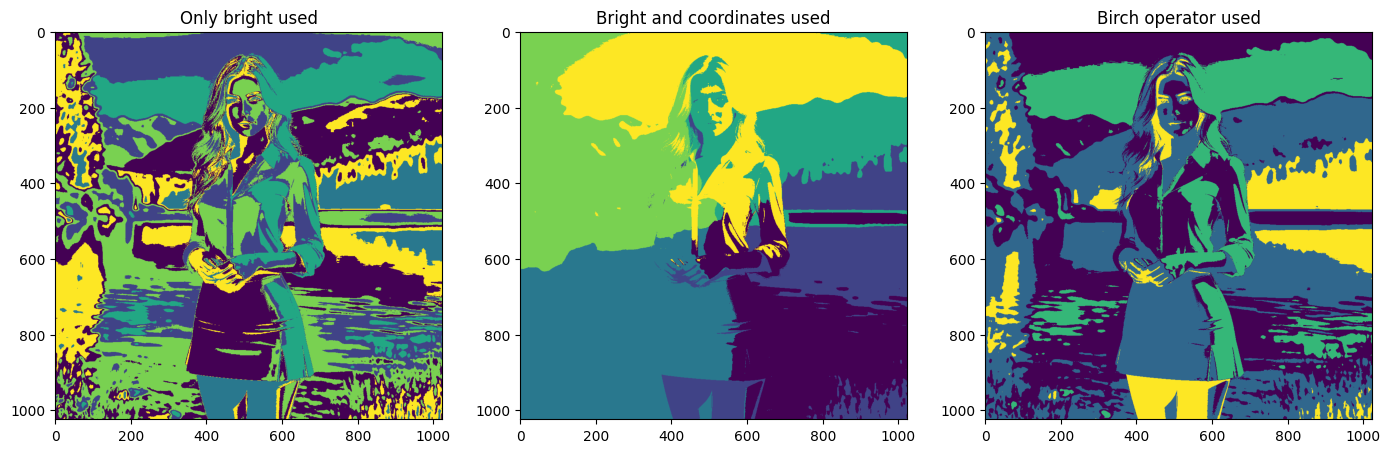

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 20))

ax[0].imshow(segmented_pic_b)
ax[0].set_title("Only bright used")
ax[1].imshow(segmented_pic_bc)
ax[1].set_title("Bright and coordinates used")
ax[2].imshow(segmented_pic_b_a)
ax[2].set_title("Birch operator used")

#### Hyperparametrs tunned

##### On bright

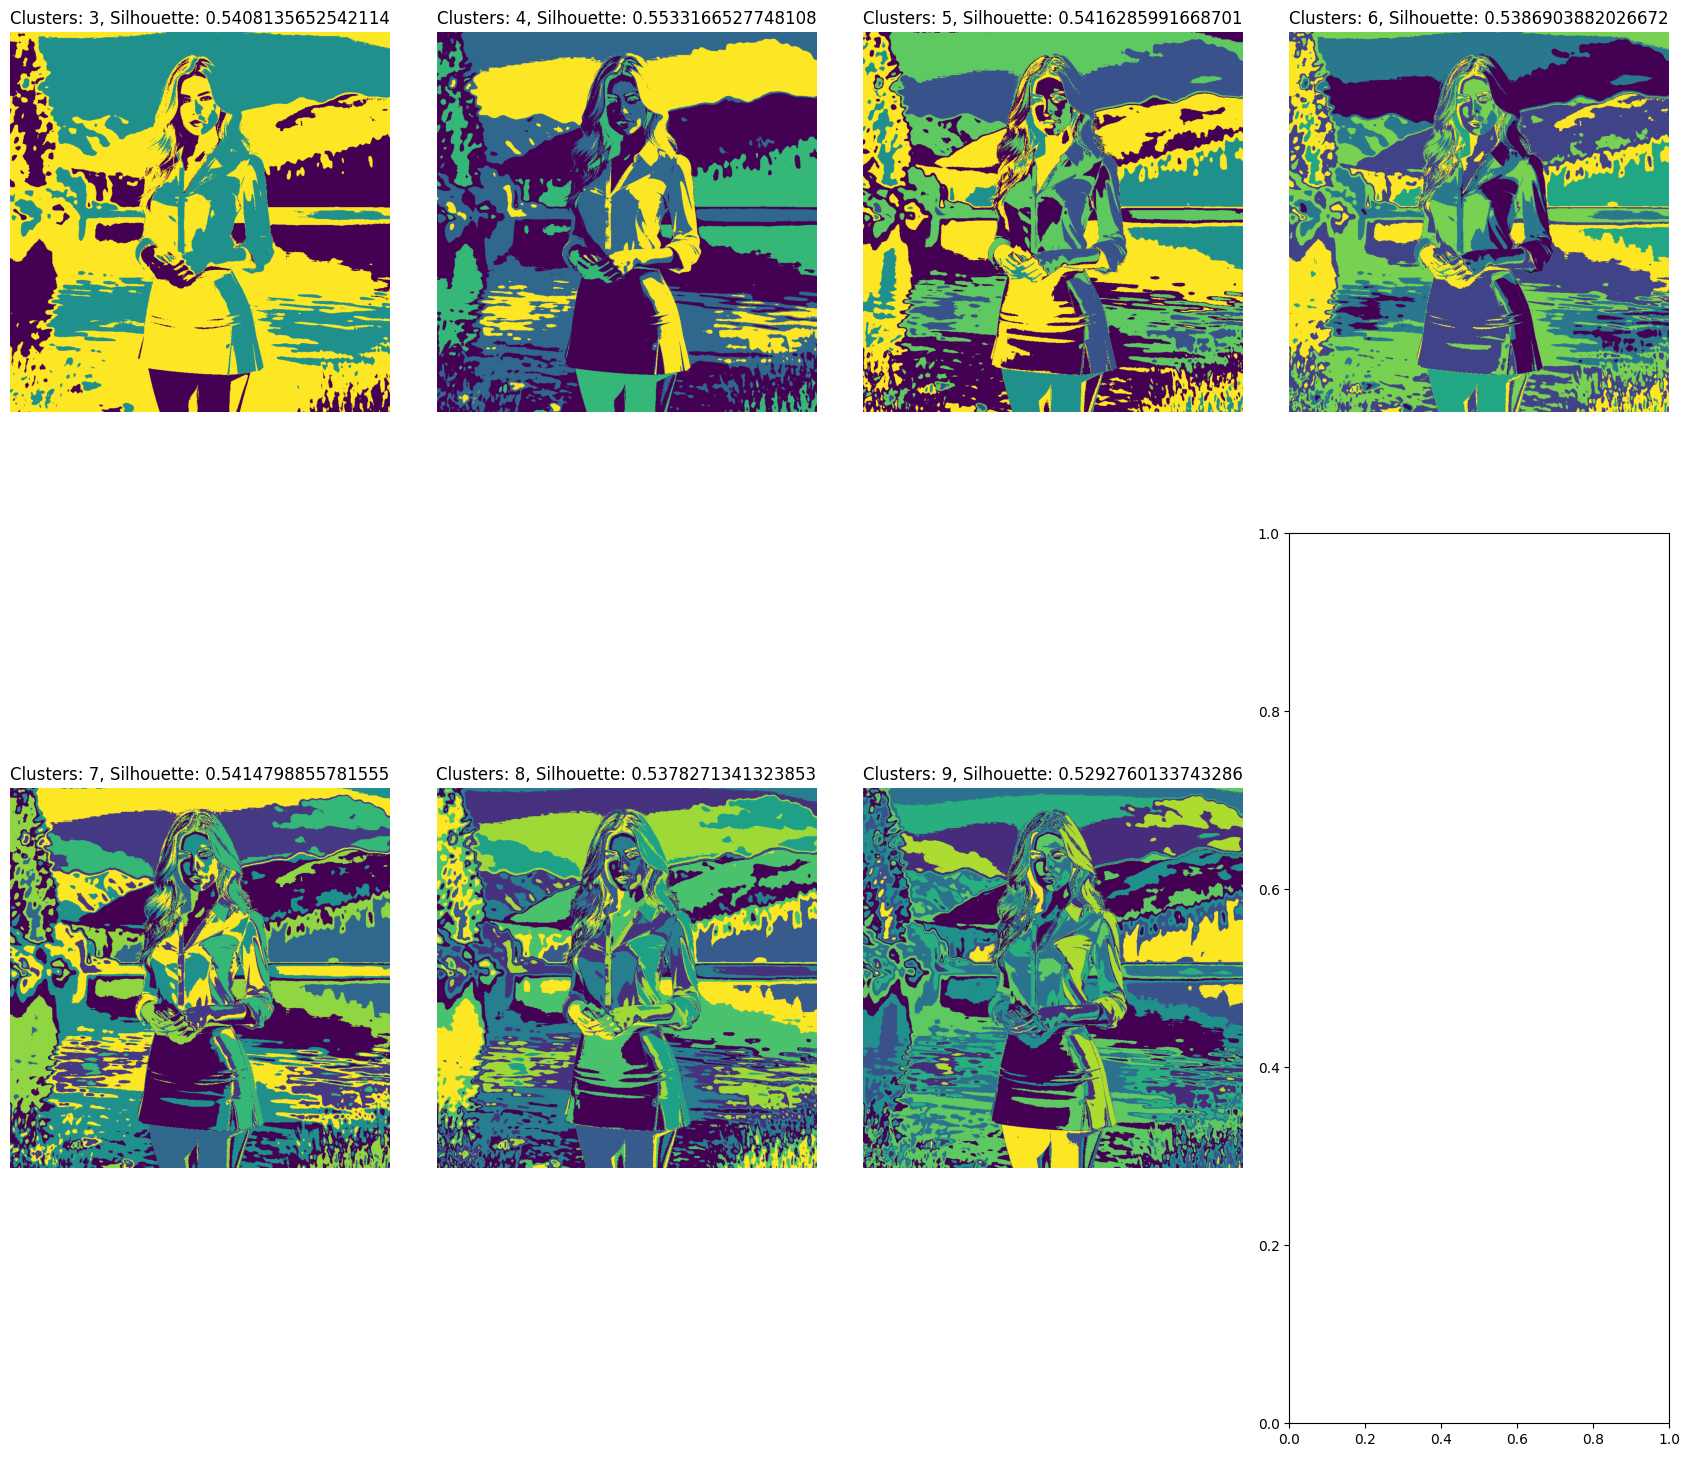

In [32]:
fig, ax = plt.subplots(2, 4, figsize=(17,17))

for i, j in enumerate(s_imgs):

    row = i // 4
    col = i % 4

    ax[row, col].imshow(j)
    ax[row, col].set_title(f"Clusters: {results[i]['clusts']}, Silhouette: {results[i]['score']}")
    ax[row, col].axis('off')

plt.tight_layout()                   
plt.show()

### DBSCAN

#### Base

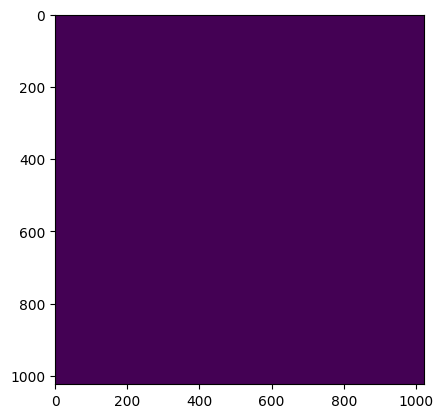

In [28]:
plt.imshow(seg_db)
plt.show()

#### Hyperparameters tunned

##### On bright

## Conturs

In [33]:
pic_counters = pic.copy()

In [ ]:
image_with_contours = pic.copy()

unique_labels = np.unique(segmented_pic_b_a)
n_clusters = len(unique_labels)

colors = []
for label in unique_labels:
    hue = int((label / n_clusters) * 179)
    color = cv2.cvtColor(np.array([[[hue, 255, 255]]], dtype=np.uint8), cv2.COLOR_HSV2BGR)
    colors.append(color[0, 0].tolist())


for i, label in enumerate(unique_labels):
    mask = np.where(segmented_pic_b_a == label, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(image_with_contours, contours, -1, colors[i], thickness=2)

cv2.imshow('Clusters Boundaries', image_with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()

Only C and default locale supported with the posix collation implementation
Only C and default locale supported with the posix collation implementation
Case insensitive sorting unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Only C and default locale supported with the posix collation implementation
Only C and default locale supported with the posix collation implementation
Case insensitive sorting unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
